In [50]:
!pip install yfinance
import numpy as np
import pandas as pd
import warnings
import os
import yfinance as yf

In [51]:
#1년

In [52]:
df = yf.download('^KS11', start = '2019-01-01', end='2019-12-31')

[*********************100%***********************]  1 of 1 completed


In [53]:
df['CODE'] = 'SPY'

In [54]:
price_df = df.loc[:,['Adj Close']].copy()

In [55]:
price_df['center'] = price_df['Adj Close'].rolling(20).mean() # 20일 이동평균선

In [56]:
# +2 표준편차를 둔 상단 밴드
price_df['ub'] = price_df['center'] + 2 * price_df['Adj Close'].rolling(20).std() 

In [57]:
# -2 표준편차를 둔 하단 밴드
price_df['lb'] = price_df['center'] - 2 * price_df['Adj Close'].rolling(20).std()

In [58]:
n = 20 #이평선
sigma = 2 #시그마

In [59]:
def bollinger_band(price_df, n, sigma):
    bb = price_df.copy()
    bb['center'] = price_df['Adj Close'].rolling(n).mean() #중앙 이동평균선
    bb['ub'] = bb['center'] + sigma * price_df['Adj Close'].rolling(n).std() # 상단 밴드
    bb['lb'] = bb['center'] - sigma * price_df['Adj Close'].rolling(n).std() # 하단 밴드
    return bb

In [60]:
bollinger = bollinger_band(price_df, n, sigma)

In [61]:
base_date = '2009-01-02'

In [62]:
sample = bollinger.loc[base_date:]

In [63]:
book = sample[['Adj Close']].copy()

In [64]:
book['trade'] = '' #거래내역 컬럼

In [65]:
def create_trade_book(sample):
    book = sample[['Adj Close']].copy()
    book['trade'] = ''
    return (book)    

In [66]:
book = create_trade_book(sample)

In [67]:
def tradings(sample, book):
    for i in sample.index:
        if sample.loc[i, 'Adj Close'] > sample.loc[i, 'ub']: # 상단밴드 이탈시 동작 안함
            book.loc[i, 'trade'] = ''
        elif sample.loc[i, 'lb'] > sample.loc[i, 'Adj Close']: # 하반밴드 이탈시 매수
            if book.shift(1).loc[i, 'trade'] == 'buy':    # 이미 매수상태라면
                book.loc[i, 'trade'] = 'buy'     # 매수상태 유지
            else:
                book.loc[i, 'trade'] = 'buy'    
        elif sample.loc[i, 'ub'] >= sample.loc[i, 'Adj Close'] and sample.loc[i, 'Adj Close'] >= sample.loc[i, 'lb']: # 볼린저 밴드 안에 있을 시
            if book.shift(1).loc[i, 'trade'] == 'buy':
                book.loc[i, 'trade'] = 'buy'  # 매수상태 유지
            else:
                book.loc[i, 'trade'] = '' # 동작 안함
    return (book) 

In [68]:
book = tradings(sample,book)

In [69]:
for i in book.index:
    if book.loc[i, 'trade'] == 'buy' and book.shift(1).loc[i, 'trade'] == '':     # long 진입
        buy = book.loc[i, 'Adj Close']
        print('진입일 : ',i, 'long 진입가격 : ', buy)
    elif book.loc[i, 'trade'] == '' and book.shift(1).loc[i, 'trade'] == 'buy':     # long 청산
        sell = book.loc[i, 'Adj Close']
        rtn = (sell - buy) / buy + 1 # 손익 계산
        book.loc[i, 'return'] = rtn
        print('청산일 : ',i, 'long 진입가격 : ', buy, ' |  long 청산가격 : ', \
              sell, ' | return:', round(rtn, 4))

    if book.loc[i, 'trade'] == '':     # zero position
        buy = 0.0
        sell = 0.0

진입일 :  2019-03-08 00:00:00 long 진입가격 :  2137.43994140625
청산일 :  2019-04-03 00:00:00 long 진입가격 :  2137.43994140625  |  long 청산가격 :  2203.27001953125  | return: 1.0308
진입일 :  2019-05-09 00:00:00 long 진입가격 :  2102.010009765625
청산일 :  2019-06-10 00:00:00 long 진입가격 :  2102.010009765625  |  long 청산가격 :  2099.489990234375  | return: 0.9988
진입일 :  2019-07-08 00:00:00 long 진입가격 :  2064.169921875
청산일 :  2019-09-04 00:00:00 long 진입가격 :  2064.169921875  |  long 청산가격 :  1988.530029296875  | return: 0.9634
진입일 :  2019-11-29 00:00:00 long 진입가격 :  2087.9599609375
청산일 :  2019-12-13 00:00:00 long 진입가격 :  2087.9599609375  |  long 청산가격 :  2170.25  | return: 1.0394


In [70]:
def returns(book):
    # 손익 계산
    rtn = 1.0
    book['return'] = 1
    buy = 0.0
    sell = 0.0
    for i in book.index:
        if book.loc[i, 'trade'] == 'buy' and book.shift(1).loc[i, 'trade'] == '':     # long 진입
            buy = book.loc[i, 'Adj Close']
            print('진입일 : ',i, 'long 진입가격 : ', buy)
        elif book.loc[i, 'trade'] == '' and book.shift(1).loc[i, 'trade'] == 'buy':     # long 청산
            sell = book.loc[i, 'Adj Close']
            rtn = (sell - buy) / buy + 1 # 손익 계산
            book.loc[i, 'return'] = rtn
            print('청산일 : ',i, 'long 진입가격 : ', buy, ' |  long 청산가격 : ', \
                  sell, ' | return:', round(rtn, 4))
    
        if book.loc[i, 'trade'] == '':     # zero position
            buy = 0.0
            sell = 0.0
    
    acc_rtn = 1.0
    for i in book.index:
        rtn = book.loc[i, 'return']
        acc_rtn = acc_rtn * rtn  # 누적 수익률 계산
        book.loc[i, 'acc return'] = acc_rtn

    print ('Accunulated return :', round(acc_rtn, 4))
    return (round(acc_rtn, 4))

In [71]:
print(returns(book))

진입일 :  2019-03-08 00:00:00 long 진입가격 :  2137.43994140625
청산일 :  2019-04-03 00:00:00 long 진입가격 :  2137.43994140625  |  long 청산가격 :  2203.27001953125  | return: 1.0308
진입일 :  2019-05-09 00:00:00 long 진입가격 :  2102.010009765625
청산일 :  2019-06-10 00:00:00 long 진입가격 :  2102.010009765625  |  long 청산가격 :  2099.489990234375  | return: 0.9988
진입일 :  2019-07-08 00:00:00 long 진입가격 :  2064.169921875
청산일 :  2019-09-04 00:00:00 long 진입가격 :  2064.169921875  |  long 청산가격 :  1988.530029296875  | return: 0.9634
진입일 :  2019-11-29 00:00:00 long 진입가격 :  2087.9599609375
청산일 :  2019-12-13 00:00:00 long 진입가격 :  2087.9599609375  |  long 청산가격 :  2170.25  | return: 1.0394
Accunulated return : 1.0309
1.0309


In [72]:
import matplotlib.pylab as plt

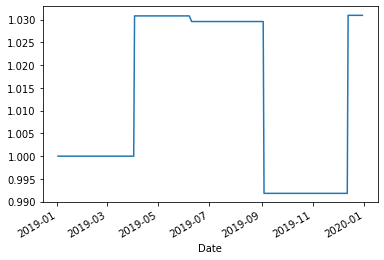

In [73]:
book['acc return'].plot()

In [74]:
#3년

In [75]:
df = yf.download('^KS11', start = '2017-01-01', end='2019-12-31')

[*********************100%***********************]  1 of 1 completed


In [76]:
df['CODE'] = 'SPY'

In [77]:
price_df = df.loc[:,['Adj Close']].copy()

In [78]:
price_df['center'] = price_df['Adj Close'].rolling(20).mean() # 20일 이동평균선

In [79]:
# +2 표준편차를 둔 상단 밴드
price_df['ub'] = price_df['center'] + 2 * price_df['Adj Close'].rolling(20).std() 

In [80]:
# -2 표준편차를 둔 하단 밴드
price_df['lb'] = price_df['center'] - 2 * price_df['Adj Close'].rolling(20).std()

In [81]:
n = 20 #이평선
sigma = 2 #시그마

In [82]:
def bollinger_band(price_df, n, sigma):
    bb = price_df.copy()
    bb['center'] = price_df['Adj Close'].rolling(n).mean() #중앙 이동평균선
    bb['ub'] = bb['center'] + sigma * price_df['Adj Close'].rolling(n).std() # 상단 밴드
    bb['lb'] = bb['center'] - sigma * price_df['Adj Close'].rolling(n).std() # 하단 밴드
    return bb

In [83]:
bollinger = bollinger_band(price_df, n, sigma)

In [84]:
base_date = '2009-01-02'

In [85]:
sample = bollinger.loc[base_date:]

In [86]:
book = sample[['Adj Close']].copy()

In [87]:
book['trade'] = '' #거래내역 컬럼

In [88]:
def create_trade_book(sample):
    book = sample[['Adj Close']].copy()
    book['trade'] = ''
    return (book)    

In [89]:
book = create_trade_book(sample)

In [90]:
def tradings(sample, book):
    for i in sample.index:
        if sample.loc[i, 'Adj Close'] > sample.loc[i, 'ub']: # 상단밴드 이탈시 동작 안함
            book.loc[i, 'trade'] = ''
        elif sample.loc[i, 'lb'] > sample.loc[i, 'Adj Close']: # 하반밴드 이탈시 매수
            if book.shift(1).loc[i, 'trade'] == 'buy':    # 이미 매수상태라면
                book.loc[i, 'trade'] = 'buy'     # 매수상태 유지
            else:
                book.loc[i, 'trade'] = 'buy'    
        elif sample.loc[i, 'ub'] >= sample.loc[i, 'Adj Close'] and sample.loc[i, 'Adj Close'] >= sample.loc[i, 'lb']: # 볼린저 밴드 안에 있을 시
            if book.shift(1).loc[i, 'trade'] == 'buy':
                book.loc[i, 'trade'] = 'buy'  # 매수상태 유지
            else:
                book.loc[i, 'trade'] = '' # 동작 안함
    return (book) 

In [91]:
book = tradings(sample,book)

In [92]:
for i in book.index:
    if book.loc[i, 'trade'] == 'buy' and book.shift(1).loc[i, 'trade'] == '':     # long 진입
        buy = book.loc[i, 'Adj Close']
        print('진입일 : ',i, 'long 진입가격 : ', buy)
    elif book.loc[i, 'trade'] == '' and book.shift(1).loc[i, 'trade'] == 'buy':     # long 청산
        sell = book.loc[i, 'Adj Close']
        rtn = (sell - buy) / buy + 1 # 손익 계산
        book.loc[i, 'return'] = rtn
        print('청산일 : ',i, 'long 진입가격 : ', buy, ' |  long 청산가격 : ', \
              sell, ' | return:', round(rtn, 4))

    if book.loc[i, 'trade'] == '':     # zero position
        buy = 0.0
        sell = 0.0

진입일 :  2017-04-11 00:00:00 long 진입가격 :  2123.85009765625
청산일 :  2017-04-25 00:00:00 long 진입가격 :  2123.85009765625  |  long 청산가격 :  2196.85009765625  | return: 1.0344
진입일 :  2017-08-09 00:00:00 long 진입가격 :  2368.389892578125
청산일 :  2017-09-18 00:00:00 long 진입가격 :  2368.389892578125  |  long 청산가격 :  2418.2099609375  | return: 1.021
진입일 :  2017-11-27 00:00:00 long 진입가격 :  2507.81005859375
청산일 :  2018-01-08 00:00:00 long 진입가격 :  2507.81005859375  |  long 청산가격 :  2513.280029296875  | return: 1.0022
진입일 :  2018-02-06 00:00:00 long 진입가격 :  2453.31005859375
청산일 :  2018-03-12 00:00:00 long 진입가격 :  2453.31005859375  |  long 청산가격 :  2484.1201171875  | return: 1.0126
진입일 :  2018-05-30 00:00:00 long 진입가격 :  2409.030029296875
청산일 :  2018-09-21 00:00:00 long 진입가격 :  2409.030029296875  |  long 청산가격 :  2339.169921875  | return: 0.971
진입일 :  2018-10-10 00:00:00 long 진입가격 :  2228.610107421875
청산일 :  2018-11-29 00:00:00 long 진입가격 :  2228.610107421875  |  long 청산가격 :  2114.10009765625  | return: 0.9486
진입일

In [93]:
def returns(book):
    # 손익 계산
    rtn = 1.0
    book['return'] = 1
    buy = 0.0
    sell = 0.0
    for i in book.index:
        if book.loc[i, 'trade'] == 'buy' and book.shift(1).loc[i, 'trade'] == '':     # long 진입
            buy = book.loc[i, 'Adj Close']
            print('진입일 : ',i, 'long 진입가격 : ', buy)
        elif book.loc[i, 'trade'] == '' and book.shift(1).loc[i, 'trade'] == 'buy':     # long 청산
            sell = book.loc[i, 'Adj Close']
            rtn = (sell - buy) / buy + 1 # 손익 계산
            book.loc[i, 'return'] = rtn
            print('청산일 : ',i, 'long 진입가격 : ', buy, ' |  long 청산가격 : ', \
                  sell, ' | return:', round(rtn, 4))
    
        if book.loc[i, 'trade'] == '':     # zero position
            buy = 0.0
            sell = 0.0
    
    acc_rtn = 1.0
    for i in book.index:
        rtn = book.loc[i, 'return']
        acc_rtn = acc_rtn * rtn  # 누적 수익률 계산
        book.loc[i, 'acc return'] = acc_rtn

    print ('Accunulated return :', round(acc_rtn, 4))
    return (round(acc_rtn, 4))

In [94]:
print(returns(book))

진입일 :  2017-04-11 00:00:00 long 진입가격 :  2123.85009765625
청산일 :  2017-04-25 00:00:00 long 진입가격 :  2123.85009765625  |  long 청산가격 :  2196.85009765625  | return: 1.0344
진입일 :  2017-08-09 00:00:00 long 진입가격 :  2368.389892578125
청산일 :  2017-09-18 00:00:00 long 진입가격 :  2368.389892578125  |  long 청산가격 :  2418.2099609375  | return: 1.021
진입일 :  2017-11-27 00:00:00 long 진입가격 :  2507.81005859375
청산일 :  2018-01-08 00:00:00 long 진입가격 :  2507.81005859375  |  long 청산가격 :  2513.280029296875  | return: 1.0022
진입일 :  2018-02-06 00:00:00 long 진입가격 :  2453.31005859375
청산일 :  2018-03-12 00:00:00 long 진입가격 :  2453.31005859375  |  long 청산가격 :  2484.1201171875  | return: 1.0126
진입일 :  2018-05-30 00:00:00 long 진입가격 :  2409.030029296875
청산일 :  2018-09-21 00:00:00 long 진입가격 :  2409.030029296875  |  long 청산가격 :  2339.169921875  | return: 0.971
진입일 :  2018-10-10 00:00:00 long 진입가격 :  2228.610107421875
청산일 :  2018-11-29 00:00:00 long 진입가격 :  2228.610107421875  |  long 청산가격 :  2114.10009765625  | return: 0.9486
진입일

In [95]:
import matplotlib.pylab as plt

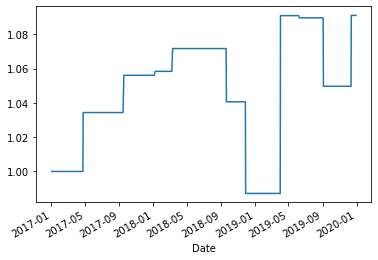

In [96]:
book['acc return'].plot()

In [97]:
#5년

In [98]:
df = yf.download('^KS11', start = '2015-01-01', end='2019-12-31')

[*********************100%***********************]  1 of 1 completed


In [99]:
df['CODE'] = 'SPY'

In [100]:
price_df = df.loc[:,['Adj Close']].copy()

In [101]:
price_df['center'] = price_df['Adj Close'].rolling(20).mean() # 20일 이동평균선

In [102]:
# +2 표준편차를 둔 상단 밴드
price_df['ub'] = price_df['center'] + 2 * price_df['Adj Close'].rolling(20).std() 

In [103]:
# -2 표준편차를 둔 하단 밴드
price_df['lb'] = price_df['center'] - 2 * price_df['Adj Close'].rolling(20).std()

In [104]:
n = 20 #이평선
sigma = 2 #시그마

In [105]:
def bollinger_band(price_df, n, sigma):
    bb = price_df.copy()
    bb['center'] = price_df['Adj Close'].rolling(n).mean() #중앙 이동평균선
    bb['ub'] = bb['center'] + sigma * price_df['Adj Close'].rolling(n).std() # 상단 밴드
    bb['lb'] = bb['center'] - sigma * price_df['Adj Close'].rolling(n).std() # 하단 밴드
    return bb

In [106]:
bollinger = bollinger_band(price_df, n, sigma)

In [107]:
base_date = '2009-01-02'

In [108]:
sample = bollinger.loc[base_date:]

In [109]:
book = sample[['Adj Close']].copy()

In [110]:
book['trade'] = '' #거래내역 컬럼

In [111]:
def create_trade_book(sample):
    book = sample[['Adj Close']].copy()
    book['trade'] = ''
    return (book)    

In [112]:
book = create_trade_book(sample)

In [113]:
def tradings(sample, book):
    for i in sample.index:
        if sample.loc[i, 'Adj Close'] > sample.loc[i, 'ub']: # 상단밴드 이탈시 동작 안함
            book.loc[i, 'trade'] = ''
        elif sample.loc[i, 'lb'] > sample.loc[i, 'Adj Close']: # 하반밴드 이탈시 매수
            if book.shift(1).loc[i, 'trade'] == 'buy':    # 이미 매수상태라면
                book.loc[i, 'trade'] = 'buy'     # 매수상태 유지
            else:
                book.loc[i, 'trade'] = 'buy'    
        elif sample.loc[i, 'ub'] >= sample.loc[i, 'Adj Close'] and sample.loc[i, 'Adj Close'] >= sample.loc[i, 'lb']: # 볼린저 밴드 안에 있을 시
            if book.shift(1).loc[i, 'trade'] == 'buy':
                book.loc[i, 'trade'] = 'buy'  # 매수상태 유지
            else:
                book.loc[i, 'trade'] = '' # 동작 안함
    return (book) 

In [114]:
book = tradings(sample,book)

In [115]:
for i in book.index:
    if book.loc[i, 'trade'] == 'buy' and book.shift(1).loc[i, 'trade'] == '':     # long 진입
        buy = book.loc[i, 'Adj Close']
        print('진입일 : ',i, 'long 진입가격 : ', buy)
    elif book.loc[i, 'trade'] == '' and book.shift(1).loc[i, 'trade'] == 'buy':     # long 청산
        sell = book.loc[i, 'Adj Close']
        rtn = (sell - buy) / buy + 1 # 손익 계산
        book.loc[i, 'return'] = rtn
        print('청산일 : ',i, 'long 진입가격 : ', buy, ' |  long 청산가격 : ', \
              sell, ' | return:', round(rtn, 4))

    if book.loc[i, 'trade'] == '':     # zero position
        buy = 0.0
        sell = 0.0

진입일 :  2015-06-03 00:00:00 long 진입가격 :  2063.159912109375
청산일 :  2015-10-08 00:00:00 long 진입가격 :  2063.159912109375  |  long 청산가격 :  2019.530029296875  | return: 0.9789
진입일 :  2015-11-10 00:00:00 long 진입가격 :  1996.5899658203125
청산일 :  2016-04-14 00:00:00 long 진입가격 :  1996.5899658203125  |  long 청산가격 :  2015.9300537109375  | return: 1.0097
진입일 :  2016-06-24 00:00:00 long 진입가격 :  1925.239990234375
청산일 :  2016-08-09 00:00:00 long 진입가격 :  1925.239990234375  |  long 청산가격 :  2043.780029296875  | return: 1.0616
진입일 :  2016-09-12 00:00:00 long 진입가격 :  1991.47998046875
청산일 :  2016-12-08 00:00:00 long 진입가격 :  1991.47998046875  |  long 청산가격 :  2031.0699462890625  | return: 1.0199
진입일 :  2017-04-11 00:00:00 long 진입가격 :  2123.85009765625
청산일 :  2017-04-25 00:00:00 long 진입가격 :  2123.85009765625  |  long 청산가격 :  2196.85009765625  | return: 1.0344
진입일 :  2017-08-09 00:00:00 long 진입가격 :  2368.389892578125
청산일 :  2017-09-18 00:00:00 long 진입가격 :  2368.389892578125  |  long 청산가격 :  2418.2099609375  | retu

In [116]:
def returns(book):
    # 손익 계산
    rtn = 1.0
    book['return'] = 1
    buy = 0.0
    sell = 0.0
    for i in book.index:
        if book.loc[i, 'trade'] == 'buy' and book.shift(1).loc[i, 'trade'] == '':     # long 진입
            buy = book.loc[i, 'Adj Close']
            print('진입일 : ',i, 'long 진입가격 : ', buy)
        elif book.loc[i, 'trade'] == '' and book.shift(1).loc[i, 'trade'] == 'buy':     # long 청산
            sell = book.loc[i, 'Adj Close']
            rtn = (sell - buy) / buy + 1 # 손익 계산
            book.loc[i, 'return'] = rtn
            print('청산일 : ',i, 'long 진입가격 : ', buy, ' |  long 청산가격 : ', \
                  sell, ' | return:', round(rtn, 4))
    
        if book.loc[i, 'trade'] == '':     # zero position
            buy = 0.0
            sell = 0.0
    
    acc_rtn = 1.0
    for i in book.index:
        rtn = book.loc[i, 'return']
        acc_rtn = acc_rtn * rtn  # 누적 수익률 계산
        book.loc[i, 'acc return'] = acc_rtn

    print ('Accunulated return :', round(acc_rtn, 4))
    return (round(acc_rtn, 4))

In [117]:
print(returns(book))

진입일 :  2015-06-03 00:00:00 long 진입가격 :  2063.159912109375
청산일 :  2015-10-08 00:00:00 long 진입가격 :  2063.159912109375  |  long 청산가격 :  2019.530029296875  | return: 0.9789
진입일 :  2015-11-10 00:00:00 long 진입가격 :  1996.5899658203125
청산일 :  2016-04-14 00:00:00 long 진입가격 :  1996.5899658203125  |  long 청산가격 :  2015.9300537109375  | return: 1.0097
진입일 :  2016-06-24 00:00:00 long 진입가격 :  1925.239990234375
청산일 :  2016-08-09 00:00:00 long 진입가격 :  1925.239990234375  |  long 청산가격 :  2043.780029296875  | return: 1.0616
진입일 :  2016-09-12 00:00:00 long 진입가격 :  1991.47998046875
청산일 :  2016-12-08 00:00:00 long 진입가격 :  1991.47998046875  |  long 청산가격 :  2031.0699462890625  | return: 1.0199
진입일 :  2017-04-11 00:00:00 long 진입가격 :  2123.85009765625
청산일 :  2017-04-25 00:00:00 long 진입가격 :  2123.85009765625  |  long 청산가격 :  2196.85009765625  | return: 1.0344
진입일 :  2017-08-09 00:00:00 long 진입가격 :  2368.389892578125
청산일 :  2017-09-18 00:00:00 long 진입가격 :  2368.389892578125  |  long 청산가격 :  2418.2099609375  | retu

In [118]:
import matplotlib.pylab as plt

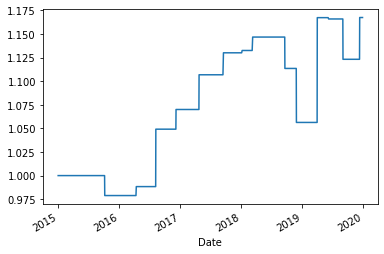

In [119]:
book['acc return'].plot()

In [120]:
#10년

In [121]:
df = yf.download('^KS11', start = '2009-01-01', end='2019-12-31')

[*********************100%***********************]  1 of 1 completed


In [122]:
df['CODE'] = 'SPY'

In [123]:
price_df = df.loc[:,['Adj Close']].copy()

In [124]:
price_df['center'] = price_df['Adj Close'].rolling(20).mean() # 20일 이동평균선

In [125]:
# +2 표준편차를 둔 상단 밴드
price_df['ub'] = price_df['center'] + 2 * price_df['Adj Close'].rolling(20).std() 

In [126]:
# -2 표준편차를 둔 하단 밴드
price_df['lb'] = price_df['center'] - 2 * price_df['Adj Close'].rolling(20).std()

In [127]:
n = 20 #이평선
sigma = 2 #시그마

In [128]:
def bollinger_band(price_df, n, sigma):
    bb = price_df.copy()
    bb['center'] = price_df['Adj Close'].rolling(n).mean() #중앙 이동평균선
    bb['ub'] = bb['center'] + sigma * price_df['Adj Close'].rolling(n).std() # 상단 밴드
    bb['lb'] = bb['center'] - sigma * price_df['Adj Close'].rolling(n).std() # 하단 밴드
    return bb

In [129]:
bollinger = bollinger_band(price_df, n, sigma)

In [130]:
base_date = '2009-01-02'

In [131]:
sample = bollinger.loc[base_date:]

In [132]:
book = sample[['Adj Close']].copy()

In [133]:
book['trade'] = '' #거래내역 컬럼

In [134]:
def create_trade_book(sample):
    book = sample[['Adj Close']].copy()
    book['trade'] = ''
    return (book)    

In [135]:
book = create_trade_book(sample)

In [136]:
def tradings(sample, book):
    for i in sample.index:
        if sample.loc[i, 'Adj Close'] > sample.loc[i, 'ub']: # 상단밴드 이탈시 동작 안함
            book.loc[i, 'trade'] = ''
        elif sample.loc[i, 'lb'] > sample.loc[i, 'Adj Close']: # 하반밴드 이탈시 매수
            if book.shift(1).loc[i, 'trade'] == 'buy':    # 이미 매수상태라면
                book.loc[i, 'trade'] = 'buy'     # 매수상태 유지
            else:
                book.loc[i, 'trade'] = 'buy'    
        elif sample.loc[i, 'ub'] >= sample.loc[i, 'Adj Close'] and sample.loc[i, 'Adj Close'] >= sample.loc[i, 'lb']: # 볼린저 밴드 안에 있을 시
            if book.shift(1).loc[i, 'trade'] == 'buy':
                book.loc[i, 'trade'] = 'buy'  # 매수상태 유지
            else:
                book.loc[i, 'trade'] = '' # 동작 안함
    return (book) 

In [137]:
book = tradings(sample,book)

In [138]:
for i in book.index:
    if book.loc[i, 'trade'] == 'buy' and book.shift(1).loc[i, 'trade'] == '':     # long 진입
        buy = book.loc[i, 'Adj Close']
        print('진입일 : ',i, 'long 진입가격 : ', buy)
    elif book.loc[i, 'trade'] == '' and book.shift(1).loc[i, 'trade'] == 'buy':     # long 청산
        sell = book.loc[i, 'Adj Close']
        rtn = (sell - buy) / buy + 1 # 손익 계산
        book.loc[i, 'return'] = rtn
        print('청산일 : ',i, 'long 진입가격 : ', buy, ' |  long 청산가격 : ', \
              sell, ' | return:', round(rtn, 4))

    if book.loc[i, 'trade'] == '':     # zero position
        buy = 0.0
        sell = 0.0

진입일 :  2009-02-20 00:00:00 long 진입가격 :  1065.949951171875
청산일 :  2009-03-17 00:00:00 long 진입가격 :  1065.949951171875  |  long 청산가격 :  1163.8800048828125  | return: 1.0919
진입일 :  2009-10-29 00:00:00 long 진입가격 :  1585.8499755859375
청산일 :  2010-03-08 00:00:00 long 진입가격 :  1585.8499755859375  |  long 청산가격 :  1660.0400390625  | return: 1.0468
진입일 :  2010-05-06 00:00:00 long 진입가격 :  1684.7099609375
청산일 :  2010-09-13 00:00:00 long 진입가격 :  1684.7099609375  |  long 청산가격 :  1818.8599853515625  | return: 1.0796
진입일 :  2011-02-09 00:00:00 long 진입가격 :  2045.5799560546875
청산일 :  2011-03-25 00:00:00 long 진입가격 :  2045.5799560546875  |  long 청산가격 :  2054.0400390625  | return: 1.0041
진입일 :  2011-05-23 00:00:00 long 진입가격 :  2055.7099609375
청산일 :  2011-07-04 00:00:00 long 진입가격 :  2055.7099609375  |  long 청산가격 :  2145.300048828125  | return: 1.0436
진입일 :  2011-08-03 00:00:00 long 진입가격 :  2066.260009765625
청산일 :  2012-01-19 00:00:00 long 진입가격 :  2066.260009765625  |  long 청산가격 :  1914.969970703125  | return:

In [139]:
def returns(book):
    # 손익 계산
    rtn = 1.0
    book['return'] = 1
    buy = 0.0
    sell = 0.0
    for i in book.index:
        if book.loc[i, 'trade'] == 'buy' and book.shift(1).loc[i, 'trade'] == '':     # long 진입
            buy = book.loc[i, 'Adj Close']
            print('진입일 : ',i, 'long 진입가격 : ', buy)
        elif book.loc[i, 'trade'] == '' and book.shift(1).loc[i, 'trade'] == 'buy':     # long 청산
            sell = book.loc[i, 'Adj Close']
            rtn = (sell - buy) / buy + 1 # 손익 계산
            book.loc[i, 'return'] = rtn
            print('청산일 : ',i, 'long 진입가격 : ', buy, ' |  long 청산가격 : ', \
                  sell, ' | return:', round(rtn, 4))
    
        if book.loc[i, 'trade'] == '':     # zero position
            buy = 0.0
            sell = 0.0
    
    acc_rtn = 1.0
    for i in book.index:
        rtn = book.loc[i, 'return']
        acc_rtn = acc_rtn * rtn  # 누적 수익률 계산
        book.loc[i, 'acc return'] = acc_rtn

    print ('Accunulated return :', round(acc_rtn, 4))
    return (round(acc_rtn, 4))

In [140]:
print(returns(book))

진입일 :  2009-02-20 00:00:00 long 진입가격 :  1065.949951171875
청산일 :  2009-03-17 00:00:00 long 진입가격 :  1065.949951171875  |  long 청산가격 :  1163.8800048828125  | return: 1.0919
진입일 :  2009-10-29 00:00:00 long 진입가격 :  1585.8499755859375
청산일 :  2010-03-08 00:00:00 long 진입가격 :  1585.8499755859375  |  long 청산가격 :  1660.0400390625  | return: 1.0468
진입일 :  2010-05-06 00:00:00 long 진입가격 :  1684.7099609375
청산일 :  2010-09-13 00:00:00 long 진입가격 :  1684.7099609375  |  long 청산가격 :  1818.8599853515625  | return: 1.0796
진입일 :  2011-02-09 00:00:00 long 진입가격 :  2045.5799560546875
청산일 :  2011-03-25 00:00:00 long 진입가격 :  2045.5799560546875  |  long 청산가격 :  2054.0400390625  | return: 1.0041
진입일 :  2011-05-23 00:00:00 long 진입가격 :  2055.7099609375
청산일 :  2011-07-04 00:00:00 long 진입가격 :  2055.7099609375  |  long 청산가격 :  2145.300048828125  | return: 1.0436
진입일 :  2011-08-03 00:00:00 long 진입가격 :  2066.260009765625
청산일 :  2012-01-19 00:00:00 long 진입가격 :  2066.260009765625  |  long 청산가격 :  1914.969970703125  | return:

In [141]:
import matplotlib.pylab as plt

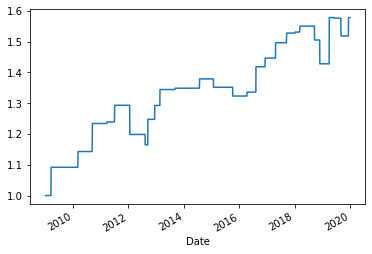

In [142]:
book['acc return'].plot()